# Initialization

In [1]:
import tensorflow
import pandas
import numpy
import math

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

from statistics import mean

import matplotlib.pyplot as plt

from google.colab import drive

# Data Import & Preparation

In [2]:
def replace_nan(x):
    if x == " ":
        return numpy.nan
    else:
        return float(x)

def remove_nan_values(x):
    return [e for e in x if not math.isnan(e)]  

In [3]:
drive.mount('/content/drive', force_remount=True)
train_file = "/content/drive/My Drive/data/Train.csv"

Mounted at /content/drive


In [4]:
data_set = pandas.read_csv(train_file)

features = ["temp", "precip", "rel_humidity", "wind_dir", "wind_spd", "atmos_press"]   
for feature in features : 
    data_set[feature] = data_set[feature].apply(lambda x: [replace_nan(X) for X in x.replace("nan", " ").split(",")])
    data_set[feature] = data_set[feature].apply(remove_nan_values)

for x in range(121):
    data_set["temp" + str(x)] = data_set.temp.str[x]
    data_set["precip" + str(x)] = data_set.precip.str[x]
    data_set["rel_humidity" + str(x)] = data_set.rel_humidity.str[x]
    data_set["wind_dir" + str(x)] = data_set.wind_dir.str[x]
    data_set["wind_spd" + str(x)] = data_set.wind_spd.str[x]
    data_set["atmos_press" + str(x)] = data_set.atmos_press.str[x]

data_set.drop(features, 1, inplace = True)

display(data_set.head())

,ID,location,target,temp0,precip0,rel_humidity0,wind_dir0,wind_spd0,atmos_press0,temp1,precip1,rel_humidity1,wind_dir1,wind_spd1,atmos_press1,temp2,precip2,rel_humidity2,wind_dir2,wind_spd2,atmos_press2,temp3,precip3,rel_humidity3,wind_dir3,wind_spd3,atmos_press3,temp4,precip4,rel_humidity4,wind_dir4,wind_spd4,atmos_press4,temp5,precip5,rel_humidity5,wind_dir5,wind_spd5,atmos_press5,temp6,...,rel_humidity114,wind_dir114,wind_spd114,atmos_press114,temp115,precip115,rel_humidity115,wind_dir115,wind_spd115,atmos_press115,temp116,precip116,rel_humidity116,wind_dir116,wind_spd116,atmos_press116,temp117,precip117,rel_humidity117,wind_dir117,wind_spd117,atmos_press117,temp118,precip118,rel_humidity118,wind_dir118,wind_spd118,atmos_press118,temp119,precip119,rel_humidity119,wind_dir119,wind_spd119,atmos_press119,temp120,precip120,rel_humidity120,wind_dir120,wind_spd120,atmos_press120
0,ID_train_0,C,45.126304,26.909091,0.000,0.510818,272.902752,0.800909,87.777273,27.208333,0.0,0.535417,104.565241,1.073333,87.652500,26.183333,0.0,0.614500,167.177225,1.517500,87.614167,24.700000,0.000,0.633000,165.332855,1.462500,87.637500,23.658333,0.000,0.683750,111.208901,0.516667,87.717500,22.741667,0.0,0.761500,86.041616,0.295000,87.762500,22.158333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ID_train_1,D,79.131702,22.533333,0.102,0.744583,281.664310,2.377500,90.320000,21.716667,0.0,0.808083,89.156293,1.126667,90.377500,20.833333,0.0,0.911167,81.968539,0.700833,90.440833,20.983333,0.000,0.916333,291.018632,0.341667,90.472500,20.875000,0.000,0.929750,279.391524,0.440833,90.454167,20.141667,0.0,0.954000,158.026892,0.380000,90.394167,19.375000,...,0.600083,97.603374,1.395833,90.481667,30.233333,0.0,0.556917,69.085542,1.589167,90.354167,30.583333,0.0,0.520833,171.660338,1.695833,90.272500,28.466667,0.0,0.603083,183.291765,2.548333,90.266667,26.991667,0.0,0.651000,213.937567,1.369167,90.325833,26.025000,0.0,0.649250,73.528733,1.475833,90.439167,21.450000,0.561,0.797333,296.967254,1.019167,90.529167
2,ID_train_10,A,32.661304,28.975000,0.000,0.573333,328.682914,1.032500,88.551667,27.950000,0.0,0.597167,307.825146,1.193333,88.464167,29.600000,0.0,0.566833,319.017751,1.275833,88.319167,26.425000,0.102,0.627667,264.865746,1.493333,88.240000,22.091667,0.136,0.755417,253.217152,1.870833,88.230000,21.775000,0.0,0.777417,251.433371,1.844167,88.268333,22.333333,...,0.881333,NaN,NaN,88.448333,23.541667,0.0,0.734750,NaN,NaN,88.500000,26.408333,0.0,0.603000,NaN,NaN,88.495000,28.075000,0.0,0.496667,NaN,NaN,88.515833,29.241667,0.0,0.459583,NaN,NaN,88.475833,30.091667,0.0,0.437917,NaN,NaN,88.415833,NaN,NaN,NaN,NaN,NaN,NaN
3,ID_train_100,A,53.850238,22.966667,0.000,0.843083,300.085057,1.446667,88.615000,24.266667,0.0,0.790250,293.676960,1.192500,88.530833,25.275000,0.0,0.737500,294.517465,1.324167,88.400000,25.625000,0.000,0.728000,301.921417,1.544167,88.271667,25.866667,0.000,0.704917,334.568073,1.915833,88.207500,25.091667,0.0,0.741167,319.576411,1.840000,88.178333,24.025000,...,0.970167,NaN,NaN,88.382500,17.625000,0.0,0.983833,NaN,NaN,88.406667,18.308333,0.0,0.990833,NaN,NaN,88.449167,20.325000,0.0,0.930417,NaN,NaN,88.507500,21.900000,0.0,0.856500,NaN,NaN,88.500000,23.533333,0.0,0.766417,NaN,NaN,88.490833,24.641667,0.000,0.719667,NaN,NaN,88.465833
4,ID_train_1000,A,177.418750,21.875000,0.000,0.856417,21.839974,0.197500,88.556667,21.575000,0.0,0.874917,17.054053,0.244167,88.640833,21.525000,0.0,0.879833,89.264060,0.411667,88.658333,21.433333,0.000,0.860167,123.585424,0.560000,88.647500,20.508333,0.000,0.898000,328.708314,0.577500,88.632500,19.916667,0.0,0.908500,117.606956,0.429167,88.586667,18.991667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
training_data = data_set.drop(["ID", 'location', 'target'], axis = 1)
training_data = numpy.nan_to_num(training_data, copy = True, nan = 0)
training_data = StandardScaler().fit(training_data).transform(training_data)
training_data = numpy.reshape(training_data, (-1, 11, 66))

training_target = data_set.target

print(training_data)
print(training_target)

[[[ 1.14015773e+00 -1.18141889e-01 -1.87490884e+00 ...  1.25929277e+00
   -5.63552403e-01 -1.13482531e+00]
  [-6.72066058e-01 -1.19036327e-01  2.87137369e-01 ... -1.69296950e+00
   -1.25992663e+00 -8.37729501e+00]
  [-5.01088161e+00 -1.19483560e-01 -4.37428745e+00 ... -1.66484664e+00
   -1.25702911e+00 -6.63328618e+00]
  ...
  [-2.67441936e+00 -1.13386069e-01 -2.56135881e+00 ... -1.31424625e+00
   -1.19193257e+00 -2.85012993e+00]
  [-2.44615948e+00 -1.12406024e-01 -2.43990889e+00 ... -1.11377767e+00
   -1.00288050e+00 -2.50889371e+00]
  [-2.21880400e+00 -1.14322240e-01 -2.22373218e+00 ... -8.31920832e-01
   -7.69451467e-01 -2.13617479e+00]]

 [[-7.65357506e-02 -4.49313439e-02 -3.26210887e-01 ...  1.07152976e+00
   -4.69867995e-01  1.21855501e+00]
  [-1.18527806e+00 -1.06343510e-01  1.14297464e+00 ... -1.00453805e+00
   -9.32482218e-02  2.17817687e-01]
  [ 2.45693211e+00 -1.19483560e-01 -2.11062517e+00 ...  8.67393939e-01
   -4.77595556e-01  2.44328022e-01]
  ...
  [ 7.64459105e-01 -1.1

In [6]:
folds=8

def gen():
    kfold = KFold(n_splits = folds, shuffle = True)
    for train, test in kfold.split(training_data, training_target):
        X_train, X_test = training_data[train], training_data[test]
        y_train, y_test = training_target[train], training_target[test] 
        yield X_train, y_train, X_test, y_test

datasets = tensorflow.data.Dataset.from_generator(gen, (tensorflow.float64, tensorflow.float64, tensorflow.float64, tensorflow.float64))

# Create CNN Model

In [7]:
lstm = tensorflow.keras.Sequential([
    tensorflow.keras.layers.LSTM(16, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(11, 66)),
    tensorflow.keras.layers.LSTM(16, recurrent_dropout=0.2),
    tensorflow.keras.layers.Dense(16, activation='relu'),
    tensorflow.keras.layers.Dense(1)
])

# Training

In [8]:
tensorflow.random.set_seed(12345)
epochs = 16

In [9]:
lstm.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.003), loss='mse', metrics=[tensorflow.keras.metrics.RootMeanSquaredError()])

results = []

for i in range(3):
    fold = 0
    for train_data, validate_data, train_target, validate_target in datasets:
        fold = fold + 1
        print("\n--- Training fold " + str(fold) + " of " + str(folds) + " ---")
        result = lstm.fit(train_data, validate_data, epochs = epochs, shuffle = False, validation_data = (train_target, validate_target))
        results.append(result.history)
    epochs = int(epochs/2)


--- Training fold 1 of 8 ---
Epoch 1/16
425/425 [==============================] - 9s 20ms/step - loss: 2377.2168 - root_mean_squared_error: 48.7567 - val_loss: 1767.4677 - val_root_mean_squared_error: 42.0413
Epoch 2/16
425/425 [==============================] - 8s 19ms/step - loss: 1536.7845 - root_mean_squared_error: 39.2018 - val_loss: 1360.3091 - val_root_mean_squared_error: 36.8824
Epoch 3/16
425/425 [==============================] - 8s 19ms/step - loss: 1337.8807 - root_mean_squared_error: 36.5771 - val_loss: 1204.3098 - val_root_mean_squared_error: 34.7032
Epoch 4/16
425/425 [==============================] - 8s 18ms/step - loss: 1213.4548 - root_mean_squared_error: 34.8347 - val_loss: 1100.2737 - val_root_mean_squared_error: 33.1704
Epoch 5/16
425/425 [==============================] - 8s 18ms/step - loss: 1104.9326 - root_mean_squared_error: 33.2405 - val_loss: 1027.0460 - val_root_mean_squared_error: 32.0476
Epoch 6/16
425/425 [==============================] - 8s 19ms/ste

# Results

In [10]:
TrainingLoss = [d['loss'] for d in results]
TrainingRMSE = [d['root_mean_squared_error'] for d in results]

In [11]:
ValidationLoss = [d['val_loss'] for d in results]
ValidationRMSE = [d['val_root_mean_squared_error'] for d in results]

In [12]:
print("Training Loss:" + str(TrainingLoss))
print("Validation Loss:" + str(ValidationLoss))
print("Training RMSE:" + str(TrainingRMSE))
print("Validation RMSE:" + str(ValidationRMSE))

Training Loss:[[2377.216796875, 1536.7845458984375, 1337.8807373046875, 1213.454833984375, 1104.9326171875, 1061.8232421875, 1032.123291015625, 1007.9619750976562, 1003.9927978515625, 981.7777099609375, 967.8533325195312, 970.4300537109375, 951.310546875, 926.2779541015625, 920.0761108398438, 899.1424560546875], [903.9021606445312, 881.1030883789062, 880.2463989257812, 861.8655395507812, 843.8834838867188, 844.92529296875, 834.102294921875, 832.4763793945312, 823.0702514648438, 812.8389282226562, 811.3445434570312, 816.8641357421875, 803.40576171875, 787.6437377929688, 790.470458984375, 792.5463256835938], [834.5139770507812, 838.05322265625, 818.5826416015625, 802.8523559570312, 809.042236328125, 793.4544677734375, 791.22119140625, 800.9178466796875, 779.703125, 798.4453735351562, 774.63671875, 774.4484252929688, 766.0023803710938, 768.211669921875, 769.773193359375, 788.6385498046875], [774.3411254882812, 756.2119140625, 760.5687866210938, 741.7708129882812, 756.9509887695312, 748.01

In [13]:
def flattenMeans(lst):
    retList = []
    for item in lst:
        retList.append(mean(item))
    return retList

TrainingLoss_means = flattenMeans(TrainingLoss)
TrainingRMSE_means = flattenMeans(TrainingRMSE)
ValidationLoss_means = flattenMeans(ValidationLoss)
ValidationRMSE_means = flattenMeans(ValidationRMSE)

print("Training Loss Means:" + str(TrainingLoss_means))
print("Validation Loss Means:" + str(ValidationLoss_means))
print("Training RMSE Means:" + str(TrainingRMSE_means))
print("Validation RMSE Means:" + str(ValidationRMSE_means))

Training Loss Means:[1143.3149375915527, 832.5430488586426, 794.2810859680176, 742.2513732910156, 722.0688095092773, 707.1878700256348, 699.7350578308105, 688.0850105285645, 669.1503982543945, 677.6099243164062, 676.5170364379883, 679.3401641845703, 662.6484375, 676.7232284545898, 667.9029159545898, 656.2139739990234, 650.7647247314453, 663.7525329589844, 645.0989074707031, 661.4615631103516, 664.4774475097656, 653.5415802001953, 663.4127502441406, 647.5420837402344]
Validation Loss Means:[1045.9443740844727, 918.8089942932129, 716.6948852539062, 736.0726356506348, 642.4882888793945, 620.3565521240234, 574.5194854736328, 614.5364799499512, 586.8651962280273, 585.7563934326172, 551.1210632324219, 530.793083190918, 566.8088302612305, 468.1118354797363, 549.6153106689453, 594.7542343139648, 568.5024719238281, 517.5611724853516, 516.2945861816406, 467.5158157348633, 452.70516204833984, 547.3798065185547, 503.18836975097656, 522.6226043701172]
Training RMSE Means:[33.49683606624603, 28.8479

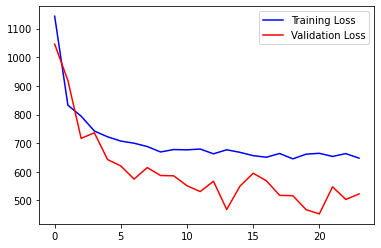

In [14]:
plt.plot(TrainingLoss_means, 'b')
plt.plot(ValidationLoss_means, 'r')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

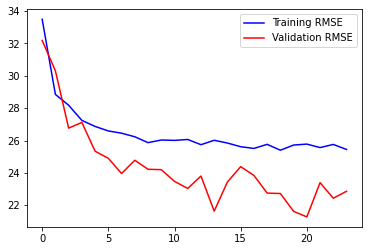

In [15]:
plt.plot(TrainingRMSE_means, 'b')
plt.plot(ValidationRMSE_means, 'r')
plt.legend(['Training RMSE', 'Validation RMSE'], loc='upper right')
plt.show()

In [16]:
print("For the last run (last 8 folds):")

print("Minimum Training Loss:\t" + str(min(TrainingLoss_means[-8:])))
print("Minimum Validation Loss:\t" + str(min(ValidationLoss_means[-8:])))
print("Mean Training Loss:\t" + str(mean(TrainingLoss_means[-8:])))
print("Mean Validation Loss:\t" + str(mean(ValidationLoss_means[-8:])))

print("Minimum Training RMSE:\t" + str(min(TrainingRMSE_means[-8:])))
print("Minimum Validation RMSE:\t" + str(min(ValidationRMSE_means[-8:])))
print("Mean Training RMSE:\t" + str(mean(TrainingRMSE_means[-8:])))
print("Mean Validation RMSE:\t" + str(mean(ValidationRMSE_means[-8:])))

For the last run (last 8 folds):
Minimum Training Loss:	645.0989074707031
Minimum Validation Loss:	452.70516204833984
Mean Training Loss:	656.2564487457275
Mean Validation Loss:	511.971248626709
Minimum Training RMSE:	25.398489475250244
Minimum Validation RMSE:	21.27563762664795
Mean Training RMSE:	25.616626858711243
Mean Validation RMSE:	22.61183226108551
